In [2]:
import os
import sys
import torch
import h5py
import diffusion_pde as dpde
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from pathlib import Path
from omegaconf import OmegaConf
from matplotlib import cm, colors
from matplotlib.axes import Axes
from matplotlib.lines import Line2D

In [3]:
def plot_M_thin_film2(
    m: np.ndarray,
    res: list[int],
    ax: plt.Axes,
    title: str | None = None,
    scale: float | None = None,
    width: float = 0.002,
    headwidth: float = 3,
    headlength: float = 5,
) -> None:
    '''
    Rework of plot_M_thin_film from magtense.utils to support subplots
    '''
    m = np.permute_dims(m, (1, 2, 0))  # CHW -> HWC
    k = np.moveaxis(m.reshape(res[1], res[0], res[2], 3).swapaxes(0, 1), -1, 0)[
        :, :, :, 0
    ]

    ax.clear()
    ax.quiver(
        k[0].T + 1e-20,
        k[1].T + 1e-20,
        pivot="mid",
        scale=scale,
        width=width,
        headwidth=headwidth,
        headlength=headlength,
    )

    nz = colors.Normalize(0.0, 2 * np.pi)
    clr = np.swapaxes(cm.hsv(nz(np.arctan2(k[1], k[0]) + np.pi)), 0, 1)
    ax.imshow(clr, interpolation="bicubic")

    ax.axis("scaled")
    #ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

    if title:
        ax.set_title(title)

In [4]:
root_dir = dpde.utils.get_repo_root()
data_dir = root_dir / "data" 

In [5]:
REFORMAT_DATABASE = False

if REFORMAT_DATABASE:
    data_path = data_dir / "llg_temp" / "200_150_64_16.h5"

    with h5py.File(data_path, "r") as f:
        field = f["field"][:]
        sequence = f["sequence"][:]
        attrs = dict(f.attrs)
    attrs["num_t_steps"] = attrs.pop("t_steps")
    [print(f"  {k}: {v}") for k, v in attrs.items()];
    sequence = np.permute_dims(sequence, (0, 4, 2, 3, 1))

    T = attrs["t_per_step"] * (attrs["num_t_steps"] - 1)
    t_steps = np.arange(attrs["num_t_steps"]) * attrs["t_per_step"]
    print(f"Total simulation time: {T:.3e} s")
    assert T == t_steps[-1]

    dx = attrs["grid_size"][0] / (attrs["res"][0] - 1)
    dy = attrs["grid_size"][1] / (attrs["res"][1] - 1)
    print(f"Grid spacing: dx = {dx:.3e} m, dy = {dy:.3e} m")

    A = sequence[..., 0]
    U = sequence[:]
    labels = field[:]

    save_path = data_dir / "llg_validate.hdf5"
    dpde.pdes.utils.save_data(
        str(save_path),
        A=A,
        U=U,
        labels=labels,
        t_steps=t_steps,
        T=T,
        dx=dx,
        dy=dy,
        **attrs
    )
else:
    save_path = data_dir / "llg_validate.hdf5"

In [6]:
with h5py.File(save_path, "r") as f:
    A = f["A"][:]
    U = f["U"][:]
    labels = f["labels"][:]
    t_steps = f["t_steps"][:]
    attrs = dict(f.attrs)
print(f"A shape: {A.shape}, U shape: {U.shape}, labels shape: {labels.shape}")
[print(f"  {k}: {v}") for k, v in attrs.items()];

A shape: (200, 3, 64, 16), U shape: (200, 3, 64, 16, 150), labels shape: (200, 3)
  N: 200
  T: 2.235e-09
  dx: 7.936507936507936e-09
  dy: 8.333333333333334e-09
  grid_size: [5.00e-07 1.25e-07 3.00e-09]
  h_ext_angle: [  0 360]
  h_ext_norm: [ 0 50]
  num_t_steps: 150
  res: [64 16  1]
  seed: 42
  t_per_step: 1.5e-11


In [7]:
dx = attrs["dx"]
dy = attrs["dy"]
T = attrs["T"]
res = attrs["res"]
grid_size = attrs["grid_size"]

In [9]:
model_path = Path("/home/s204790/dynamical-pde-diffusion/pretrained_models/llg_llg_unet_v2.pth")
cfg_path = Path("/home/s204790/dynamical-pde-diffusion/logs/hydra/2025-11-10_16-00-41/.hydra/config.yaml")
cfg = OmegaConf.load(cfg_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

edm = dpde.utils.get_net_from_config(cfg)
edm.to(device)

edm.load_state_dict(torch.load(model_path, weights_only=True))

RuntimeError: Error(s) in loading state_dict for EDMWrapper:
	Missing key(s) in state_dict: "unet.down_conv.0.0.weight", "unet.down_conv.0.0.bias", "unet.down_conv.1.1.weight", "unet.down_conv.1.1.bias", "unet.down_conv.2.1.weight", "unet.down_conv.2.1.bias", "unet.down_conv.3.1.weight", "unet.down_conv.3.1.bias", "unet.up_conv.0.0.weight", "unet.up_conv.0.0.bias", "unet.up_conv.1.0.weight", "unet.up_conv.1.0.bias", "unet.up_conv.2.0.weight", "unet.up_conv.2.0.bias", "unet.up_conv.3.0.weight", "unet.up_conv.3.0.bias", "unet.up_conv.3.2.weight", "unet.up_conv.3.2.bias", "unet.linear_embed.0.weight", "unet.linear_embed.0.bias", "unet.linear_embed.1.weight", "unet.linear_embed.1.bias", "unet.linear_embed.2.weight", "unet.linear_embed.2.bias", "unet.linear_embed.3.weight", "unet.linear_embed.3.bias". 
	Unexpected key(s) in state_dict: "unet.down_blocks.down_6->32_down.conv1.weight", "unet.down_blocks.down_6->32_down.conv1.bias", "unet.down_blocks.down_6->32_down.conv2.weight", "unet.down_blocks.down_6->32_down.conv2.bias", "unet.down_blocks.down_6->32_down.emb_layer.weight", "unet.down_blocks.down_6->32_down.emb_layer.bias", "unet.down_blocks.down_6->32_down.norm1.weight", "unet.down_blocks.down_6->32_down.norm1.bias", "unet.down_blocks.down_6->32_down.norm2.weight", "unet.down_blocks.down_6->32_down.norm2.bias", "unet.down_blocks.down_6->32_down.skip.1.weight", "unet.down_blocks.down_6->32_down.skip.1.bias", "unet.down_blocks.down_32->64_down.conv1.weight", "unet.down_blocks.down_32->64_down.conv1.bias", "unet.down_blocks.down_32->64_down.conv2.weight", "unet.down_blocks.down_32->64_down.conv2.bias", "unet.down_blocks.down_32->64_down.emb_layer.weight", "unet.down_blocks.down_32->64_down.emb_layer.bias", "unet.down_blocks.down_32->64_down.norm1.weight", "unet.down_blocks.down_32->64_down.norm1.bias", "unet.down_blocks.down_32->64_down.norm2.weight", "unet.down_blocks.down_32->64_down.norm2.bias", "unet.down_blocks.down_32->64_down.skip.1.weight", "unet.down_blocks.down_32->64_down.skip.1.bias", "unet.down_blocks.down_64->128_down.conv1.weight", "unet.down_blocks.down_64->128_down.conv1.bias", "unet.down_blocks.down_64->128_down.conv2.weight", "unet.down_blocks.down_64->128_down.conv2.bias", "unet.down_blocks.down_64->128_down.emb_layer.weight", "unet.down_blocks.down_64->128_down.emb_layer.bias", "unet.down_blocks.down_64->128_down.norm1.weight", "unet.down_blocks.down_64->128_down.norm1.bias", "unet.down_blocks.down_64->128_down.norm2.weight", "unet.down_blocks.down_64->128_down.norm2.bias", "unet.down_blocks.down_64->128_down.skip.1.weight", "unet.down_blocks.down_64->128_down.skip.1.bias", "unet.down_blocks.down_128->256_.conv1.weight", "unet.down_blocks.down_128->256_.conv1.bias", "unet.down_blocks.down_128->256_.conv2.weight", "unet.down_blocks.down_128->256_.conv2.bias", "unet.down_blocks.down_128->256_.emb_layer.weight", "unet.down_blocks.down_128->256_.emb_layer.bias", "unet.down_blocks.down_128->256_.norm1.weight", "unet.down_blocks.down_128->256_.norm1.bias", "unet.down_blocks.down_128->256_.norm2.weight", "unet.down_blocks.down_128->256_.norm2.bias", "unet.down_blocks.down_128->256_.skip.weight", "unet.down_blocks.down_128->256_.skip.bias", "unet.up_blocks.up_256->128_.conv1.weight", "unet.up_blocks.up_256->128_.conv1.bias", "unet.up_blocks.up_256->128_.conv2.weight", "unet.up_blocks.up_256->128_.conv2.bias", "unet.up_blocks.up_256->128_.emb_layer.weight", "unet.up_blocks.up_256->128_.emb_layer.bias", "unet.up_blocks.up_256->128_.norm1.weight", "unet.up_blocks.up_256->128_.norm1.bias", "unet.up_blocks.up_256->128_.norm2.weight", "unet.up_blocks.up_256->128_.norm2.bias", "unet.up_blocks.up_256->128_.skip.weight", "unet.up_blocks.up_256->128_.skip.bias", "unet.up_blocks.up_128->64_up.conv1.1.weight", "unet.up_blocks.up_128->64_up.conv1.1.bias", "unet.up_blocks.up_128->64_up.conv2.weight", "unet.up_blocks.up_128->64_up.conv2.bias", "unet.up_blocks.up_128->64_up.emb_layer.weight", "unet.up_blocks.up_128->64_up.emb_layer.bias", "unet.up_blocks.up_128->64_up.norm1.weight", "unet.up_blocks.up_128->64_up.norm1.bias", "unet.up_blocks.up_128->64_up.norm2.weight", "unet.up_blocks.up_128->64_up.norm2.bias", "unet.up_blocks.up_128->64_up.skip.1.weight", "unet.up_blocks.up_128->64_up.skip.1.bias", "unet.up_blocks.up_64->32_up.conv1.1.weight", "unet.up_blocks.up_64->32_up.conv1.1.bias", "unet.up_blocks.up_64->32_up.conv2.weight", "unet.up_blocks.up_64->32_up.conv2.bias", "unet.up_blocks.up_64->32_up.emb_layer.weight", "unet.up_blocks.up_64->32_up.emb_layer.bias", "unet.up_blocks.up_64->32_up.norm1.weight", "unet.up_blocks.up_64->32_up.norm1.bias", "unet.up_blocks.up_64->32_up.norm2.weight", "unet.up_blocks.up_64->32_up.norm2.bias", "unet.up_blocks.up_64->32_up.skip.1.weight", "unet.up_blocks.up_64->32_up.skip.1.bias", "unet.up_blocks.up_32->6_up.conv1.1.weight", "unet.up_blocks.up_32->6_up.conv1.1.bias", "unet.up_blocks.up_32->6_up.conv2.weight", "unet.up_blocks.up_32->6_up.conv2.bias", "unet.up_blocks.up_32->6_up.emb_layer.weight", "unet.up_blocks.up_32->6_up.emb_layer.bias", "unet.up_blocks.up_32->6_up.norm1.weight", "unet.up_blocks.up_32->6_up.norm1.bias", "unet.up_blocks.up_32->6_up.norm2.weight", "unet.up_blocks.up_32->6_up.norm2.bias", "unet.up_blocks.up_32->6_up.skip.1.weight", "unet.up_blocks.up_32->6_up.skip.1.bias". 

In [8]:
idx = 0   # which sample to visualize
t_idx = 20  # which time step to visualize

t = t_steps[t_idx].item()
lbl = labels[idx, :]
a = A[idx, :]  # (S, S)
u = U[idx, :, :, :, t_idx]  # (S, S)

a.shape, u.shape

((3, 64, 16), (3, 64, 16))

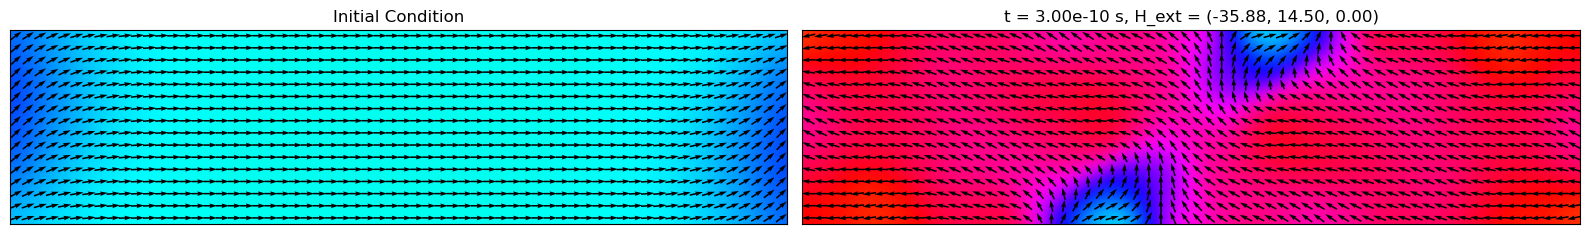

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
plot_M_thin_film2(a, res=res, ax=axs[0], title="Initial Condition")
plot_M_thin_film2(u, res=res, ax=axs[1], title=f"t = {t:.2e} s, H_ext = ({", ".join([f'{h:.2f}' for h in lbl])})")
plt.tight_layout()
plt.show()

In [10]:
sample_shape = cfg.dataset.sampling.sample_shape
generator = torch.Generator().manual_seed(0)

interior_a = 1.0
boundary_a = 1.0

interior_u = 0.0
boundary_u = 0.0

boundary_obs_a = dpde.validation.random_boundary_mask(sample_shape[1], sample_shape[2], frac_obs=boundary_a)
interior_obs_a = dpde.validation.random_interior_mask(sample_shape[1], sample_shape[2], frac_obs=interior_a)

boundary_obs_u = dpde.validation.random_boundary_mask(sample_shape[1], sample_shape[2], frac_obs=boundary_u)
interior_obs_u = dpde.validation.random_interior_mask(sample_shape[1], sample_shape[2], frac_obs=interior_u)

mask_a = dpde.validation.combine_masks(boundary_obs_a, interior_obs_a)
mask_u = dpde.validation.combine_masks(boundary_obs_u, interior_obs_u)

In [20]:
from magtense.micromag import MicromagProblem


def llg_loss(
    x, dxdt, obs_a, obs_u, mask_a, mask_u, dx, dy, ch_a, labels, cuda: bool = True
):
    """
    Compute the Landau-Lifshitz-Gilbert (LLG) equation loss components.

    LLG in MagTense notation:
        dm_dt = - gamma * (m x H_eff) - alpha * m x (m x H_eff)
        H_eff = H_ext + H_demag + H_exch + H_anis

    Choice for muMAG Std problem #4 (https://www.ctcms.nist.gov/~rdm/std4/spec4.html):
        H_anis = 0
        H_ext = (known) constant external field
        H_demag = computed via magnetostatic equations (not included here)
        H_exch = (2 A / (mu0 Ms)) * Laplacian(m)

    Following parameters are fixed for simplicity, can be modified as needed:
        gamma = 2.21e5  # gyromagnetic ratio [m/(A s)]
        alpha = 4.42e3  # damping constant
        A0 = 1.3e-11    # exchange stiffness [J/m]
        Ms = 8e5        # saturation magnetization [A/m]
        K0 = 0.0        # anisotropy constant [J/m^3]

    Parameters
    ----------
    x : torch.Tensor
        Current state tensor of shape (B, C, H, W), where C = ch_a + ch_u.
    dxdt : torch.Tensor
        Time derivative of x, tensor of shape (B, C, H, W).
    obs_a : torch.Tensor
        Observations of the initial condition, tensor of shape (B, ch_a, H, W).
    obs_u : torch.Tensor
        Observations of the solution at time T, tensor of shape (B, ch_u, H, W).
    mask_a : torch.Tensor
        Binary mask for obs_a, tensor of shape (B, ch_a, H, W).
    mask_u : torch.Tensor
        Binary mask for obs_u, tensor of shape (B, ch_u, H, W).
    dx : float
        Spatial grid size in x-direction.
    dy : float
        Spatial grid size in y-direction.
    ch_a : int
        Number of channels for the initial condition.
    labels : torch.Tensor
        External magnetic field vector of shape (B, 3).

    Returns
    -------
    loss_pde : torch.Tensor
        PDE loss component.
    loss_obs_a : torch.Tensor
        Observation loss component for the initial condition.
    loss_obs_u : torch.Tensor
        Observation loss component for the solution at time T.
    """
    # Magnetization vector (B, 3, H, W)
    m = x[:, ch_a:, :, :]
    # Initial condition vector (B, ch_a, H, W)
    a = x[:, :ch_a, :, :]
    n_magnets = m.shape[-1] * m.shape[-2]
    # Time derivative of Magnetization vector (B, 3, H, W)
    dmdt = dxdt[:, ch_a:, :, :]

    dtype = torch.float32
    res = [64, 16, 1]
    grid_size = [500e-9, 125e-9, 3e-9]
    mu0 = 4e-7 * torch.pi
    t_per_step = 4e-12
    gamma = 2.21e5
    alpha = 4.42e3
    A0 = 1.3e-11
    Ms = 8e5
    K0 = 0.0

    # Reshape to (B, 3, 1, 1) for broadcasting and bring to units [A/m]
    h_ext = (labels.view(x.shape[0], 3, 1, 1) / (1000 * mu0)).detach().cpu()
    h_eff = torch.zeros_like(m).detach().cpu()

    # Iterate over batch dimension to compute fields for each sample
    for i in range(m.shape[0]):
        n_magnets = res[0] * res[1] * res[2]

        # Reshape from  (3, H, W) to (n_magnets, 3)
        m_mt = m[i].swapaxes(1, 2).reshape(3, -1).T.detach().cpu().numpy()
        problem_dym = MicromagProblem(
            res=res,
            grid_L=grid_size,
            m0=m_mt,
            alpha=alpha,
            gamma=gamma,
            A0=A0,
            Ms=Ms,
            K0=K0,
            usereturnhall=1,
            cuda=cuda,
        )

        def h_ext_fct(t) -> np.ndarray:
            return np.expand_dims(t > -1, axis=1) * h_ext[i, :, 0, 0].detach().cpu().numpy()

        devnull = open("/dev/null", "w")
        oldstdout_fno = os.dup(sys.stdout.fileno())
        os.dup2(devnull.fileno(), 1)
        h_e, _, h_d, h_a = problem_dym.run_simulation(
            t_end=t_per_step * 9,
            nt=10,  # Minimum number of steps for rksuite of MagTense to work properly
            fct_h_ext=h_ext_fct,
            nt_h_ext=100,
        )[3:7]
        os.dup2(oldstdout_fno, 1)

        # Reshape back to (3, H, W) and negate fields as MagTense returns -H
        h_exch = torch.tensor(
            -h_e[1, :, 0].copy().T.reshape(3, res[1], res[0]).swapaxes(1, 2),
            dtype=dtype,
        )
        h_demag = torch.tensor(
            -h_d[1, :, 0].copy().T.reshape(3, res[1], res[0]).swapaxes(1, 2),
            dtype=dtype,
        )
        h_anis = torch.tensor(
            -h_a[1, :, 0].copy().T.reshape(3, res[1], res[0]).swapaxes(1, 2),
            dtype=dtype,
        )
        h_eff[i] = h_ext[i] + h_exch + h_demag + h_anis
        
    h_eff = h_eff.to(m.device)
    # Compute the LLG right-hand side
    mxH = torch.cross(m, h_eff, dim=1)
    m_cross_mxH = torch.cross(m, mxH, dim=1)
    llg_rhs = -gamma * mxH - alpha * m_cross_mxH

    loss_pde = (torch.norm(dmdt - llg_rhs * t_per_step, dim=1, p=2) / n_magnets).sum()  #dim=1
    # enforce |m| = 1 constraint
    loss_norm = torch.norm(m, p=2, dim=1) - 1

    loss_obs_a = torch.norm(mask_a * (a - obs_a), p=2)
    loss_obs_u = torch.norm(mask_u * (m - obs_u), p=2)

    return loss_pde, loss_obs_a, loss_obs_u


In [21]:
obs_a = torch.tensor(a)
obs_u = torch.tensor(u)

ch_a = 3

sample_shape = (1, 6, 64, 16)

zeta_a = 50.0
zeta_u = 20.0
zeta_pde = 1.5

num_steps = 23

t_cond = torch.full((sample_shape[0], 1), t)
h_ext = torch.tensor(lbl).unsqueeze(0).repeat(sample_shape[0], 1)
lbls = torch.cat([t_cond, h_ext], dim=-1)

lbls.shape

loss_fn_kwargs = {
    "obs_a": obs_a,
    "obs_u": obs_u,
    "mask_a": mask_a,
    "mask_u": mask_u,
    "dx": dx,
    "dy": dx,
    "ch_a": ch_a,
    "labels": h_ext,
}

torch.backends.cudnn.conv.fp32_precision = 'tf32'

#for i in range(10):
samples, losses = dpde.sampling.edm_sampler(
    net=edm,
    device=device,
    sample_shape=sample_shape,
    loss_fn=llg_loss,
    loss_fn_kwargs=loss_fn_kwargs,
    labels=lbls,
    zeta_a=zeta_a,
    zeta_u=zeta_u,
    zeta_pde=zeta_pde,
    num_steps=num_steps,
    to_cpu=True,
    debug=True,
    return_losses=True,
    compile_net=False,
)
print(f"Final total loss: {losses[-1, 3]:.4f}")
samples = samples.numpy()

Final total loss: 56.8782


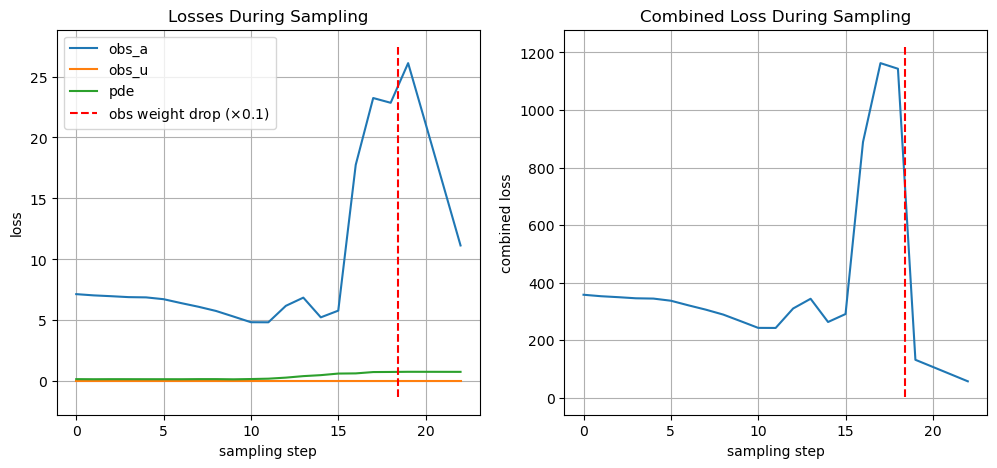

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(losses[:, :3])
axs[0].set(xlabel='sampling step', ylabel='loss', title="Losses During Sampling")
axs[0].grid()
axs[1].plot(losses[:, 3])
axs[1].set(xlabel='sampling step', ylabel='combined loss', title="Combined Loss During Sampling")
axs[1].grid()
for i in range(2):
    temp_min, temp_max = axs[i].get_ylim()
    axs[i].vlines(0.8 * num_steps, ymin=temp_min, ymax=temp_max, color='red', linestyle='--')
axs[0].legend(['obs_a', 'obs_u', 'pde', 'obs weight drop ($\\times 0.1$)'])
plt.show()

In [14]:
rng = np.random.default_rng()

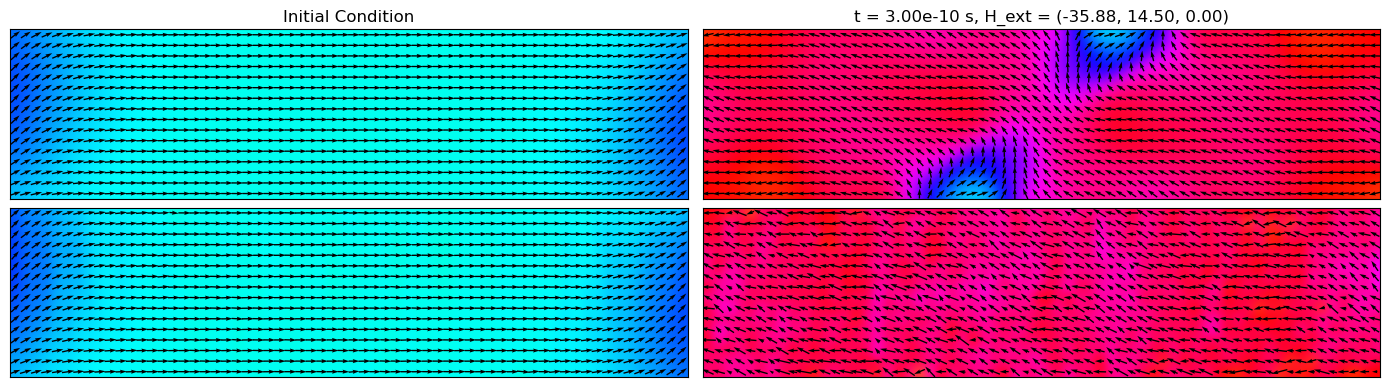

In [15]:
num_samples_plot = 1
fig, axs = plt.subplots(num_samples_plot + 1, 2, figsize=(14, 2 * (num_samples_plot + 1)))

plot_M_thin_film2(a, res=res, ax=axs[0, 0], title="Initial Condition")
plot_M_thin_film2(u, res=res, ax=axs[0, 1], title=f"t = {t:.2e} s, H_ext = ({", ".join([f'{h:.2f}' for h in lbl])})")
for i in range(num_samples_plot):
    idx = rng.integers(0, samples.shape[0])
    plot_M_thin_film2(samples[idx, :ch_a, ...], res=res, ax=axs[i + 1, 0])
    plot_M_thin_film2(samples[idx, ch_a:, ...], res=res, ax=axs[i + 1, 1])
plt.tight_layout()
plt.show()

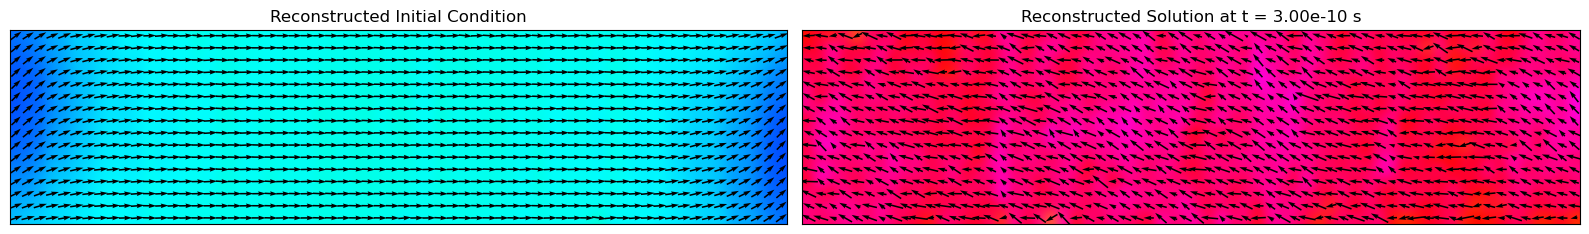

In [45]:
average_a = samples[:, :ch_a, ...].mean(axis=0)
average_u = samples[:, ch_a:, ...].mean(axis=0)

fig, axs = plt.subplots(1, 2, figsize=(16, 4))
plot_M_thin_film2(average_a, res=res, ax=axs[0], title="Reconstructed Initial Condition")
plot_M_thin_film2(average_u, res=res, ax=axs[1], title=f"Reconstructed Solution at t = {t:.2e} s")
plt.tight_layout()
plt.show()

In [41]:
samples.shape

(32, 6, 64, 16)

In [42]:
std_u = samples[:, ch_a:, ...].std(axis=(0, 1))

In [43]:
std_u.shape

(64, 16)

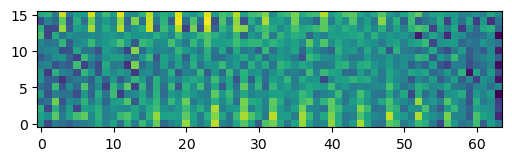

In [44]:
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(std_u.T, cmap='viridis', origin='lower')